<a href="https://colab.research.google.com/github/asagar60/Neural-Style-Transfer/blob/master/pytorch_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
import requests

In [2]:
from google.colab import files
upload = files.upload()

Saving shutterstock_737988934-1366x800@2x.jpg to shutterstock_737988934-1366x800@2x.jpg
Saving potrait.jpg to potrait (1).jpg


In [3]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad = False

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [5]:
def load_image(img_path, max_size = 400, shape = None):

  if 'http' in img_path:
    response = requests.get(img_path)
    image = Image.open(BytesIO(response.content)).convert('RGB')
  else:
    image = Image.open(img_path).convert('RGB')
  
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
  
  if shape is not None:
    size = shape

  in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
  image = in_transform(image)[:3,:,:].unsqueeze(0)
  
  return image

In [15]:
content = load_image('/content/face_potrait.jpg').to(device)
style = load_image('/content/potrait.jpg', shape = content.shape[-2:]).to(device)

In [16]:
def im_convert(tensor):
  image = tensor.to('cpu').clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)

  return image

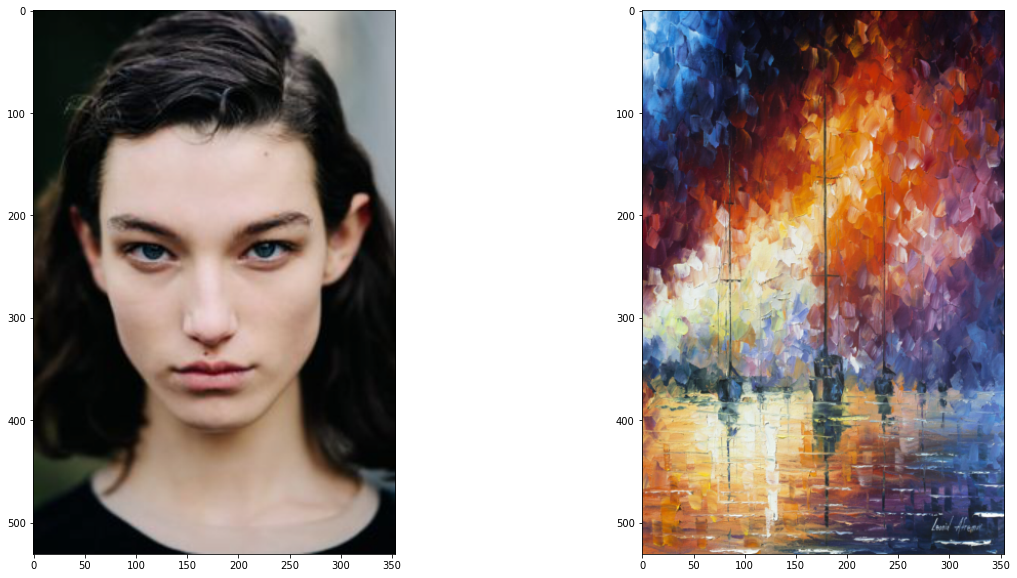

In [17]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [18]:
def get_features(image, model, layers = None):
  if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
  features = {}
  x = image

  for name, layer in model._modules.items():
    x  = layer(x)
    if name in layers:
      features[layers[name]] = x
  return features

In [19]:
def gram_matrix(tensor):

  batch, d, h, w = tensor.size()
  tensor = tensor.view(d, h*w)

  gram = torch.mm(tensor, tensor.t())
  return gram

In [20]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

In [21]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

# you may choose to leave these as is
content_weight = 1  # alpha
style_weight = 1e6  # beta

Total Loss:  773023.9375


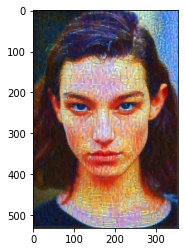

Total Loss:  220603.875


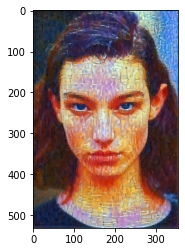

Total Loss:  149679.0625


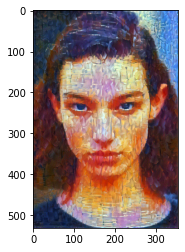

Total Loss:  261773.6875


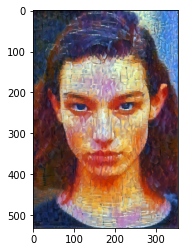

Total Loss:  109684.203125


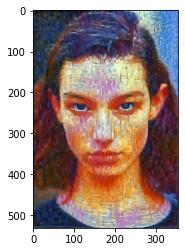

In [22]:
show_every = 400
optimizer = optim.Adam([target], lr = 0.03)
steps = 2000

for i in range(1, steps+1):
  target_features  = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

  style_loss = 0

  for layer in style_weights:
    target_feature = target_features[layer]
    _,d,h,w = target_feature.shape

    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]

    layer_style_loss = style_weights[layer] *  torch.mean((target_gram - style_gram)**2)
    style_loss += layer_style_loss /(d*h*w)
  total_loss = content_weight * content_loss + style_weight*style_loss

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print('Total Loss: ', total_loss.item())
    plt.imshow(im_convert(target))
    plt.show()

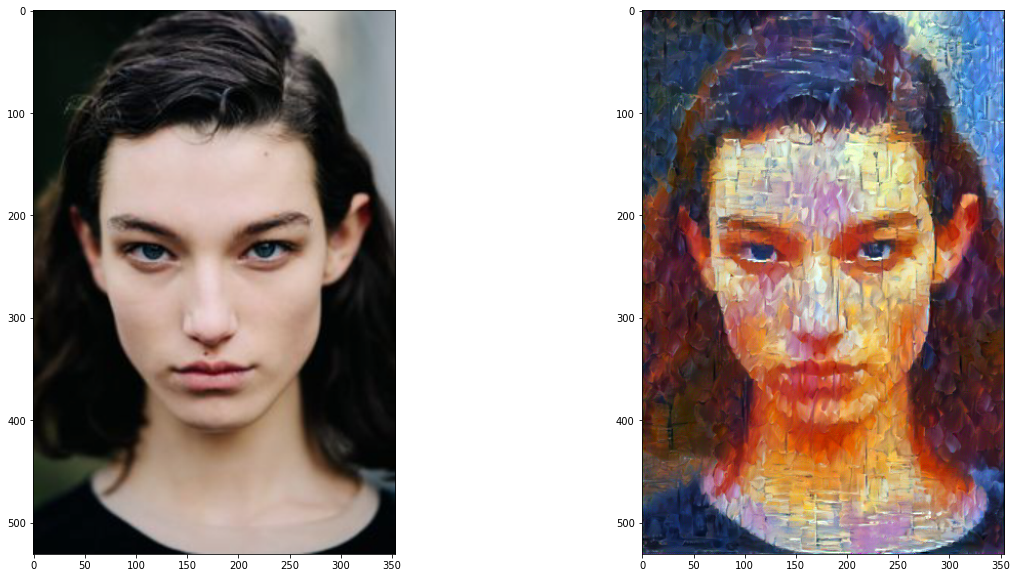

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))